In [1]:
import json
import numpy as np
import pandas as pd

import sys
sys.path.append('../GillesPy2/')
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment, export_StochSS
from gillespy2 import ODECSolver, ODESolver, SSACSolver

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets
from IPython.display import display

## Read in observed data

In [2]:
# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)

obs = np.vstack([devil_pop]).reshape(1, 1, -1)

# Devils DFTD 2-Stage Infection with Vaccination and Culling

In [3]:
variables = {
    "vaccinated_infection_rate": "0.1", # % of "break-through" cases
    "vaccination_proportion": "0.85",  # % of devil population that get vaccinated
    "vaccine_frequency": "6", #times per year we drop bait
    "vaccine_time": "0", # number of months after current date (0==Nov 2021)
    "program_length": "20", # number of years
    "end_sim": 1000,
    "cull_rate_infected": 0.01,
    "cull_rate_diseased": 0.2,
    "cull_start": 525,
}
variables_orig = variables.copy()

In [4]:
dates = []
year = 1985
while len(dates) < variables['end_sim'] + 1:
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

In [5]:
class DevilsDFTD2StageInfectionWithVaccination(Model):
    def __init__(self, values=variables):
        Model.__init__(self, name="Devils DFTD 2-Stage Infection with Vaccination")
        self.volume = 1

        # Parameters (Pre-Vaccination)
        birth_rate = Parameter(name="birth_rate", expression="0.055")
        death_rate_diseased = Parameter(name="death_rate_diseased", expression="0.048")
        death_rate_infected = Parameter(name="death_rate_infected", expression="0.03")
        death_rate_juvenile = Parameter(name="death_rate_juvenile", expression="0.006")
        death_rate_over_population = Parameter(name="death_rate_over_population", expression="2.3e-07")
        death_rate_susceptible = Parameter(name="death_rate_susceptible", expression="0.02335")
        incubation = Parameter(name="incubation", expression="22.6")
        infection_rate_diseased = Parameter(name="infection_rate_diseased", expression="3e-05")
        infection_rate_infected = Parameter(name="infection_rate_infected", expression="2e-05")
        maturity_rate = Parameter(name="maturity_rate", expression="0.04267")
        progression = Parameter(name="progression", expression="12")
        DFTD_introduction = Parameter(name="DFTD_introduction", expression="40")
        self.add_parameter([
            birth_rate, death_rate_diseased, death_rate_infected, death_rate_juvenile, death_rate_over_population,
            death_rate_susceptible, incubation, infection_rate_diseased, infection_rate_infected,
            maturity_rate, progression, DFTD_introduction
        ])
        
        # Parameters (Vaccination)
        vaccinated_infection_rate = Parameter(
            name="vaccinated_infection_rate", expression=values['vaccinated_infection_rate']
        )
        vaccination_proportion = Parameter(name="vaccination_proportion", expression=values['vaccination_proportion'])
        vaccine_frequency = Parameter(name="vaccine_frequency", expression=values['vaccine_frequency'])
        vaccine_time = Parameter(name="vaccine_time", expression=values['vaccine_time'])
        program_length = Parameter(name="program_length", expression=values['program_length'])
        self.add_parameter([
            vaccinated_infection_rate, vaccination_proportion, vaccine_frequency, vaccine_time, program_length
        ])
        
        # Parameter (Culling)
        cull_rate_diseased = Parameter(name="cull_rate_diseased", expression=0)
        cull_rate_infected = Parameter(name="cull_rate_infected", expression=0)
        self.add_parameter([
            cull_rate_diseased, cull_rate_infected, 
        ])
        
        # Variables (Pre-Vaccination)
        init_Devils_pop = round(devil_pop[0])
        init_J_pop = round(devil_pop[0] * 0.467)
        init_S_pop = round(devil_pop[0] - init_J_pop)
        
        Devils = Species(name="Devils", initial_value=init_Devils_pop, mode="discrete")
        Diseased = Species(name="Diseased", initial_value=0, mode="discrete")
        Exposed = Species(name="Exposed", initial_value=0, mode="discrete")
        Infected = Species(name="Infected", initial_value=0, mode="discrete")
        Juvenile = Species(name="Juvenile", initial_value=init_S_pop, mode="discrete")
        Susceptible = Species(name="Susceptible", initial_value=init_J_pop, mode="discrete")
        self.add_species([Devils, Diseased, Exposed, Infected, Juvenile, Susceptible])
        
        # Variables (Vaccination)
        Vaccinated = Species(name="Vaccinated", initial_value=0, mode="discrete")
        self.add_species(Vaccinated)
        
        # Reactions (Pre-Vaccination)
        Birth = Reaction(name="Birth",
            reactants={}, products={'Juvenile': 1, 'Devils': 1},
            propensity_function="birth_rate * (Susceptible + Exposed + Infected + Vaccinated)"
        )
        Mature = Reaction(name="Mature",
            reactants={'Juvenile': 1}, products={'Susceptible': 1},
            propensity_function="Juvenile * maturity_rate"
        )
        Death_Diseased = Reaction(name="Death_Diseased",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_diseased * Diseased"
        )
        Death_Diseased2 = Reaction(name="Death_Diseased2",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Diseased * (Devils - 1)"
        )
        Death_Exposed = Reaction(name="Death_Exposed",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible * Exposed"
        )
        Death_Exposed2 = Reaction(name="Death_Exposed2",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_over_population * Exposed * (Devils - 1)"
        )
        Death_Infected = Reaction(name="Death_Infected",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_infected * Infected"
        )
        Death_Infected2 = Reaction(name="Death_Infected2",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Infected * (Devils-1)"
        )
        Death_Juvenile = Reaction(name="Death_Juvenile",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_juvenile * Juvenile"
        )
        Death_Juvenile2 = Reaction(name="Death_Juvenile2",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Juvenile * (Devils-1)"
        )
        Death_Susceptible = Reaction(name="Death_Susceptible",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible * Susceptible"
        )
        Death_Susceptible2 = Reaction(name="Death_Susceptible2",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Susceptible * (Devils-1)"
        )
        DFTD_Stage1 = Reaction(name="DFTD_Stage1",
            reactants={'Exposed': 1}, products={'Infected': 1},
            propensity_function="Exposed / incubation"
        )
        DFTD_Stage2 = Reaction(name="DFTD_Stage2",
            reactants={'Infected': 1}, products={'Diseased': 1},
            propensity_function="Infected / progression"
        )
        TransmissionD = Reaction(name="TransmissionD",
            reactants={'Susceptible': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased': 1},
            propensity_function="infection_rate_diseased * Susceptible * Diseased"
        )
        TransmissionI = Reaction(name="TransmissionI",
            reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected': 1},
            propensity_function="infection_rate_infected * Susceptible * Infected"
        )
        self.add_reaction([
            Birth, Mature, Death_Diseased, Death_Diseased2, Death_Exposed, Death_Exposed2, Death_Infected,
            Death_Infected2, Death_Juvenile, Death_Juvenile2, Death_Susceptible, Death_Susceptible2,
            DFTD_Stage1, DFTD_Stage2, TransmissionD, TransmissionI
        ])
        
        # Reactions (Vaccination)
        Vaccine_Failure_I = Reaction(name="Vaccine_Failure_I",
            reactants={'Vaccinated': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected': 1},
            propensity_function="infection_rate_infected * vaccinated_infection_rate * Vaccinated * Infected / \
                                            (Susceptible + Exposed + Infected + Vaccinated + Diseased + Juvenile)"
        )
        Vaccine_Failure_D = Reaction(name="Vaccine_Failure_D",
            reactants={'Vaccinated': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased': 1},
            propensity_function="infection_rate_diseased * vaccinated_infection_rate * Vaccinated * Diseased / \
                                            (Susceptible + Exposed + Infected + Vaccinated + Diseased + Juvenile)"
        )
        Death_Vaccinated = Reaction(name="Death_Vaccinated",
            reactants={'Devils': 1, 'Vaccinated': 1}, products={},
            propensity_function="death_rate_susceptible * Vaccinated"
        )
        Death_Vaccinated2 = Reaction(name="Death_Vaccinated2",
            reactants={'Devils': 1, 'Vaccinated': 1}, products={},
            propensity_function="death_rate_over_population * Vaccinated * (Devils - 1)"
        )
        self.add_reaction([Vaccine_Failure_I, Vaccine_Failure_D, Death_Vaccinated, Death_Vaccinated2])


        
        # Reactions (Culling)
        Death_Cull_Infected = Reaction(name="Death_Cull_Infected",
            reactants={'Devils': 1, 'Infected': 1}, products={},
            propensity_function="cull_rate_infected * Infected"
        )
        Death_Cull_Diseased = Reaction(name="Death_Cull_Diseased",
            reactants={'Devils': 1, 'Diseased': 1}, products={},
            propensity_function="cull_rate_diseased * Diseased"
        )
        self.add_reaction([Death_Cull_Infected, Death_Cull_Diseased])
        
        
        
        
#         # Event Triggers
#         DFTD_Introduction_trig = EventTrigger(expression="t >= DFTD_introduction", initial_value=False, persistent=False)
#         Vaccination_trig = EventTrigger(expression="t >= 442 + vaccine_time and program_length > 0", initial_value=False, persistent=True)

#         # Event Assignments
#         DFTD_Introduction_assign_1 = EventAssignment(variable="Infected", expression="1")
#         DFTD_Introduction_assign_2 = EventAssignment(variable="Susceptible", expression="Susceptible - 1")
#         Vaccination_assign_1 = EventAssignment(variable="vaccine_time", expression="vaccine_time + 12 / vaccine_frequency")
#         Vaccination_assign_2 = EventAssignment(variable="program_length", expression="program_length - (12 / vaccine_frequency) / 12")
#         Vaccination_assign_3 = EventAssignment(variable="Vaccinated", expression="Vaccinated + (Susceptible * vaccination_proportion)")
#         Vaccination_assign_4 = EventAssignment(variable="Susceptible", expression="Susceptible * (1 - vaccination_proportion)")

#         # Events
#         self.add_event(Event(name="DFTD_Introduction", trigger=DFTD_Introduction_trig, assignments=[DFTD_Introduction_assign_1, DFTD_Introduction_assign_2], delay=None, priority="0", use_values_from_trigger_time=False))
#         self.add_event(Event(name="Vaccination", trigger=Vaccination_trig, assignments=[Vaccination_assign_1, Vaccination_assign_2, Vaccination_assign_3, Vaccination_assign_4], delay=None, priority="0", use_values_from_trigger_time=True))

        # Timespan
        self.timespan(np.arange(0, values['end_sim'] + 1, 1))
        
    def __fix_shape(self, result):
        if result['time'].size < result['Devils'].size:
            for species in self.listOfSpecies.keys():
                result[0][species] = result[0][species][:-1]
        return result
    
    def __run_vaccine_period(self, resume, t, kwargs):
        vaccination_proportion = float(variables['vaccination_proportion'])
        susceptible_pop = int(resume[0]['Susceptible'][-1] * (1 - vaccination_proportion))
        vaccinated_pop = int(resume[0]['Vaccinated'][-1] + resume[0]['Susceptible'][-1] * vaccination_proportion)
        kwargs['variables']['Susceptible'] = susceptible_pop
        kwargs['variables']['Vaccinated'] = vaccinated_pop
        return self.__fix_shape(super().run(resume=resume, t=t, **kwargs))
    
    def run(self, with_pr=False, **kwargs):
        if not with_pr:
            return super().run(**kwargs)
                
        self.resolve_parameters()
        if not "variables" in kwargs.keys():
            kwargs['variables'] = {}
            cull_rate_infected = 0
            cull_rate_diseased = 0
        else:
            cull_rate_infected = kwargs['variables']['cull_rate_infected']
            cull_rate_diseased = kwargs['variables']['cull_rate_diseased']
        # set cull rate to zero
        kwargs['variables']['cull_rate_infected'] = "0"
        kwargs['variables']['cull_rate_diseased'] = "0"

        # Run Pre-infection Period
        t = int(self.listOfParameters['DFTD_introduction'].value)
        res1 = super().run(**kwargs, t=t)
        
        
        # Configure Infection Period
        kwargs['variables']['Infected'] = "1"
        kwargs['variables']['Susceptible'] = f"{int(res1[0]['Susceptible'][-1] - 1)}"
        
        # Run Infection Period
        t = 442 + int(variables['vaccine_time'])
        result = self.__fix_shape(super().run(resume=res1, t=t, **kwargs))
        while result['Infected'][-1] <= 0:
            result = self.__fix_shape(super().run(resume=res1, t=t, **kwargs))
                    
        # Configure Vaccination Period
        del kwargs['variables']['Infected']
        vaccine_frequency = int(variables['vaccine_frequency'])
        program_length = int(variables['program_length'])
        time_diff = 12 / vaccine_frequency
        program_end = t + (time_diff * (vaccine_frequency * program_length))
        
        # Run Vaccination Period
        while t < program_end:
            t += time_diff
            if(t >= kwargs['variables']['cull_start']):
                kwargs['variables']['cull_rate_infected'] = cull_rate_infected
                kwargs['variables']['cull_rate_diseased'] = cull_rate_diseased
            
            result = self.__run_vaccine_period(resume=result, t=t, kwargs=kwargs)
            
        del kwargs['variables']['Susceptible']
        del kwargs['variables']['Vaccinated']
        return self.__fix_shape(super().run(resume=result, **kwargs))

In [6]:
model = DevilsDFTD2StageInfectionWithVaccination()

# Simulation Parameters

In [7]:
def configure_simulation():
    solver = SSACSolver(model=model, variable=True)
    kwargs = {
        "solver": solver,
        "number_of_trajectories": 1,
        "variables" : variables
    }
    return kwargs

In [8]:
kwargs = configure_simulation()
results = model.run(with_pr=True, **kwargs)

# Visualization

In [9]:
def plot(results, start=0, alpha=0.3):
    carry_cap = int(max(devil_pop)*1.16)
    dftd_start = int(results.model.listOfParameters['DFTD_introduction'].value)
    vaccine_start = int(442 + int(variables['vaccine_time']))
    spec_list = [results['Juvenile'], results['Susceptible'], results['Exposed'],
                 results['Infected'], results['Diseased'], results['Vaccinated']]
    total_devils = np.add.reduce(spec_list)
    x = results['time'][start:]
    text_offset = (results['time'].size - start) / 601
    
    plt.figure(figsize=[15, 8])
    plt.title("Tasmanian Devil Population with DFTD: Vaccination Program", fontsize=18)
    plt.xlabel(f"Time (months) since {dates[start]}", fontsize=14)
    plt.ylabel("Population of Tasmanian Devils", fontsize=14)
    plt.plot(x, total_devils[start:], color='blue', label='Total Devils')
    plt.plot(x, results['Juvenile'][start:], color='purple', alpha=alpha, label='Juvenile')
    plt.plot(x, results['Susceptible'][start:], color='green', alpha=alpha, label='Susceptible')
    plt.plot(x, results['Exposed'][start:], color='magenta', alpha=alpha, label='Exposed')
    plt.plot(x, results['Infected'][start:], color='red', alpha=alpha, label='Infected')
    plt.plot(x, results['Diseased'][start:], color='brown', alpha=alpha, label='Diseased')
    plt.plot(x, results['Vaccinated'][start:], color='cyan', alpha=alpha, label='Vaccinated')
    plt.ylim([-3000, carry_cap])
    if start <= dftd_start:
        plt.plot([dftd_start, dftd_start], [-3000, carry_cap], '--r', alpha=0.3)
        plt.text(dftd_start-10*text_offset, 45000, "DFTD Introduced", rotation="vertical", color="red", fontsize=12)
        plt.text(dftd_start+3*text_offset, 48000, dates[dftd_start], rotation="vertical", color="red", fontsize=12)
    plt.plot([vaccine_start, vaccine_start], [-3000, carry_cap], '--r', alpha=0.3)
    plt.text(vaccine_start-10*text_offset, 30000,
             "Start Vaccination Program", rotation="vertical", color="red", fontsize=12)
    plt.text(vaccine_start+3*text_offset, 37000,
             dates[vaccine_start], rotation="vertical", color="red", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation="vertical", va="center")
    plt.legend(loc='best', fontsize=12)

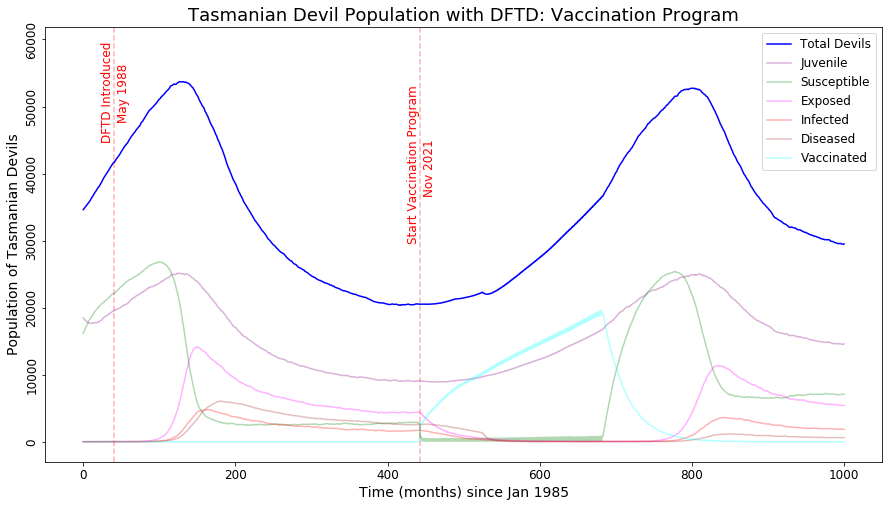

In [10]:
plot(results)

In [11]:
solver = SSACSolver(model, variable=True)

## Configure Solver Widgets

In [12]:
def display_details():
    width = 112
    d_width = width - 4
    h_width = int(d_width/2)
    pad = "    "
    pnt_els = ['='*width]
    
    # Changes to parameters
    pnt_els.append(" ".join(['|', 'Input Parameters:'.ljust(d_width), '|']))
    date = dates[442 + int(variables["vaccine_time"])]
    vt_line = f'{pad}Vaccination Program Start: {variables["vaccine_time"]} ({date})'
    if variables["vaccine_time"] != variables_orig["vaccine_time"]:
        prev_date = dates[442 + int(variables_orig["vaccine_time"])]
        vt_line += f'{pad}(was {variables_orig["vaccine_time"]} ({prev_date}))'
    pnt_els.append(" ".join(['|', vt_line.ljust(d_width), '|']))
    
    plvf_line = f'{pad}Progam Length (years): {variables["program_length"]}'
    if variables["program_length"] != variables_orig["program_length"]:
        plvf_line += f'{pad}(was {variables_orig["program_length"]})'
    plvf_line = plvf_line.ljust(h_width)
    plvf_line += f'{pad}Vaccine Frequency (per year): {variables["vaccine_frequency"]}'
    if variables["vaccine_frequency"] != variables_orig["vaccine_frequency"]:
        plvf_line += f'{pad}(was {variables_orig["vaccine_frequency"]})'
    pnt_els.append(" ".join(['|', plvf_line.ljust(d_width), '|']))
    
    vpvi_line = f'{pad}Vaccination Proportion: {variables["vaccination_proportion"]}'
    if variables["vaccination_proportion"] != variables_orig["vaccination_proportion"]:
        vpvi_line += f'{pad}(was {variables_orig["vaccination_proportion"]})'
    vpvi_line = vpvi_line.ljust(h_width)
    vpvi_line += f'{pad}Vaccinated Infection Rate: {variables["vaccinated_infection_rate"]}'
    if variables["vaccinated_infection_rate"] != variables_orig["vaccinated_infection_rate"]:
        vpvi_line += f'{pad}(was {variables_orig["vaccinated_infection_rate"]})'
    pnt_els.append(" ".join(['|', vpvi_line.ljust(d_width), '|']))
    pnt_els.append('='*width)
    
    print("\n".join(pnt_els))

In [13]:
Saved_Results = None
def configure(vaccinated_infection_rate, vaccination_proportion, start,
              vaccine_frequency, vaccine_time, program_length, end_sim,
              cull_rate_infected, cull_rate_diseased):
    global Saved_Results
    
    variables['vaccinated_infection_rate'] = str(vaccinated_infection_rate)
    variables['vaccination_proportion'] = str(vaccination_proportion)
    variables['vaccine_frequency'] = str(vaccine_frequency)
    variables['vaccine_time'] = str(vaccine_time)
    variables['program_length'] = str(program_length)
    variables['end_sim'] = end_sim
    variables['cull_rate_infected'] = cull_rate_infected
    variables['cull_rate_diseased'] = cull_rate_diseased
    
    model.timespan(np.arange(0, end_sim + 1, 1))
    
    display_details()
    
    variable = {
        "vaccinated_infection_rate": vaccinated_infection_rate,
        "vaccination_proportion": vaccination_proportion,
        "vaccine_frequency": vaccine_frequency,
        "vaccine_time": vaccine_time,
        "program_length": program_length,
        "cull_rate_infected": cull_rate_infected,
        "cull_rate_diseased": cull_rate_diseased,
        "cull_start" : variables['cull_start']
    }
    results = model.run(with_pr=True, solver=solver, variables=variable)
    Saved_Results = results
    plot(results, start=start)

## Create Widgets

In [14]:
s1 = widgets.IntSlider(
    min=430, max=1000, step=1, value=variables['end_sim'], description="Sim. End"
)
s2 = widgets.IntSlider(
    min=0, max=200, step=1, value=variables['vaccine_time'], description="Vaccine Start"
)
s3 = widgets.IntSlider(
    min=1, max=30, step=1, value=variables['program_length'], description="Prog. Len."
)
s4 = widgets.IntSlider(
    min=1, max=12, step=1, value=variables['vaccine_frequency'], description="Vaccine Freq."
)
s5 = widgets.FloatSlider(
    min=0.01, max=1, step=0.01, value=variables['vaccination_proportion'], description="Vacc. Prop."
)
s6 = widgets.FloatSlider(
    min=0.01, max=1, step=0.01, value=variables['vaccinated_infection_rate'], description="Vacc. Inf. R."
)
s7 = widgets.IntSlider(
    min=0, max=419, step=12, value=0, description="Start"
)
s8 = widgets.FloatSlider(
    min=0.01, max=1, step=0.01, value=variables['cull_rate_infected'], description="Cull. Inf. R."
)
s9 = widgets.FloatSlider(
    min=0.01, max=1, step=0.01, value=variables['cull_rate_diseased'], description="Cull. Dis. R."
)


ai_widgets = {'end_sim': s1, 'vaccine_time': s2, 'program_length': s3,
              'vaccine_frequency': s4, 'vaccination_proportion': s5,
              'vaccinated_infection_rate': s6, "start": s7, "cull_rate_infected": s8,
              "cull_rate_diseased": s9
             }

In [15]:
def get_layout(vertical=False):
    kwargs = {
        "margin": '0px 10px 10px 0px',
        "padding": '5px 5px 5px 5px'
    }
    if not vertical:
        kwargs['border'] = 'solid 1px red'
    return widgets.Layout(**kwargs)

hb1 = widgets.HBox([s7, s1, s2], layout=get_layout())
hb2 = widgets.HBox([s3, s4, s8], layout=get_layout())
hb3 = widgets.HBox([s5, s6, s9], layout=get_layout())

ui = widgets.VBox([hb1, hb2, hb3])

## Run widgets and attempt to calibrate model

In [16]:
out = interactive_output(configure, ai_widgets)
display(out, ui)

Output()

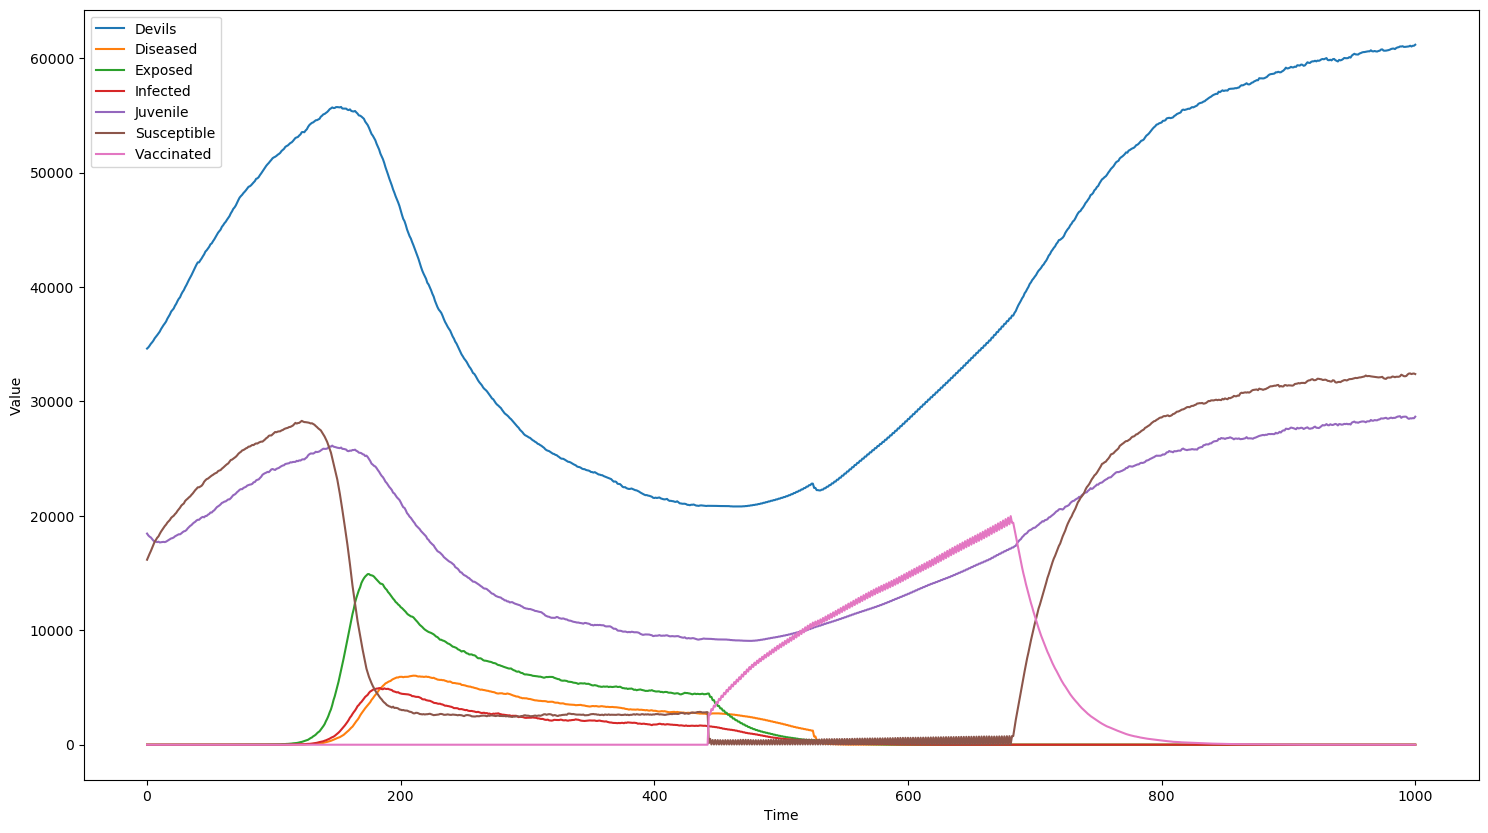

In [25]:
Saved_Results.plot()

In [26]:
Saved_Results.plotplotly()

In [27]:
Dftd = Saved_Results[0]['Infected'] + Saved_Results[0]['Exposed']+ Saved_Results[0]['Diseased']

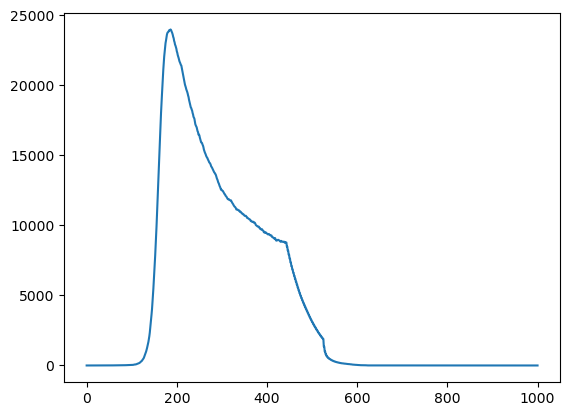

In [28]:
plt.plot(Dftd)

In [29]:
min(Dftd[150:])

0.0

In [30]:
variables

{'vaccinated_infection_rate': '0.1',
 'vaccination_proportion': '0.95',
 'vaccine_frequency': '6',
 'vaccine_time': '0',
 'program_length': '20',
 'end_sim': 1000,
 'cull_rate_infected': 0.01,
 'cull_rate_diseased': 0.5,
 'cull_start': 525}

In [31]:
def compute_dftd_extinction_prob():
    print(variables)
    ext_count = 0
    for _ in range(100):
        print(".", end='')
        res = model.run(with_pr=True, solver=solver, variables=variables)
        Dftd = res[0]['Infected'] + res[0]['Exposed']+ res[0]['Diseased']
        if min(Dftd[150:]) == 0.0:
            ext_count+=1
    print()
    print(f"Dftd extinction={ext_count/100.0}")

In [32]:
raise Exception('stop... no run-all past here')

Exception: stop... no run-all past here

In [33]:
compute_dftd_extinction_prob()

{'vaccinated_infection_rate': '0.1', 'vaccination_proportion': '0.95', 'vaccine_frequency': '6', 'vaccine_time': '0', 'program_length': '20', 'end_sim': 1000, 'cull_rate_infected': 0.01, 'cull_rate_diseased': 0.5, 'cull_start': 525}
....................................................................................................
Dftd extinction=0.43
